<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/2023-2/notebooks/5c_gmm_em.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EM para modelo de mezclas gaussianas
En esta libreta veremos cómo programar el algoritmo EM para estimar los parámetros por máxima verosimilitud del modelo de mezclas gaussianas. 

In [1]:
!wget -q https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv

## Cargamos los datos
Evaluaremos este algoritmo en el conjunto de datos Old Faithful, compuesto de 272 mediciones del géiser de erupciones en Yellowstone National Park en Estados Unidos.

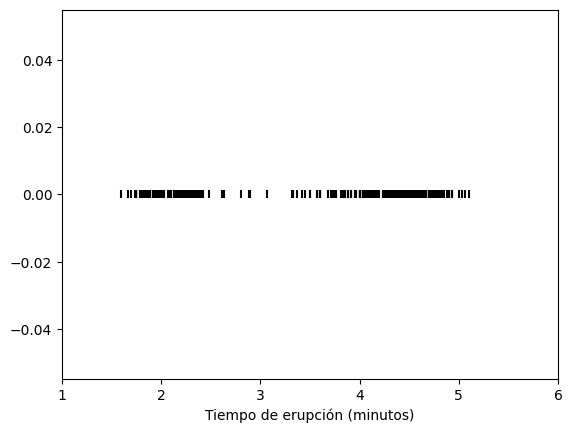

In [2]:
import numpy as np
np.random.seed(1)
import pandas as pd

import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

data = pd.read_csv('data.tsv', delimiter='\t')
plt.scatter(data['eruptions'], y=np.zeros(data['eruptions'].shape[0]), color='black', marker='|')
plt.xlim([1,6])
plt.savefig('datos.pdf')
plt.xlabel('Tiempo de erupción (minutos)')
plt.savefig('datos.pdf')

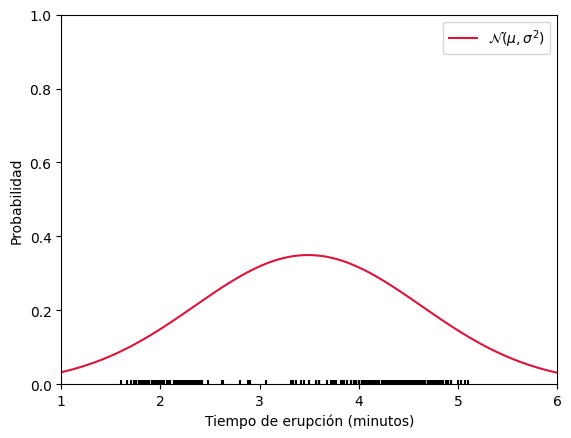

In [3]:
m = data['eruptions'].mean()
s = data['eruptions'].std()
x = np.linspace(norm.ppf(0.01, loc=m, scale=s), norm.ppf(0.99, loc=m, scale=s), 100)

plt.scatter(data['eruptions'], y=np.zeros(data['eruptions'].shape[0]), color='black', marker='|')
plt.plot(x, norm.pdf(x,  loc=m, scale=s), color='crimson', label='$\mathcal{N}(\mu, \sigma^2)$')
plt.xlim([1,6])
plt.ylim([0,1])
plt.xlabel('Tiempo de erupción (minutos)')
plt.ylabel('Probabilidad')
plt.legend()
plt.savefig('onegauss.pdf')

## Algoritmo EM para MMG
Primero definimos una función para visualizar las distribuciones de nuestro modelo de mezclas dados los parámetros y las responsabilidades.

In [4]:
def grafica_distribuciones(datos, pi, mu, sigma, n_comp, posteriori, nombre):
  x = np.linspace(1, 6, num=1000)
  normal_0 = norm.pdf(x, loc=mu[0], scale=np.sqrt(sigma[0]))
  normal_1 = norm.pdf(x, loc=mu[1], scale=np.sqrt(sigma[1]))
  mezcla = pi[0] * normal_0 +  pi[1] * normal_1
  plt.plot(x, mezcla, label='$\pi_0\mathcal{N}(\mu_0, \sigma_0^2) + \pi_1\mathcal{N}(\mu_1, \sigma_1^2)$', color='g', linestyle='--', linewidth=4, alpha=0.5)
  plt.plot(x, pi[0] * normal_0, label='$\pi_0\mathcal{N}(\mu_0, \sigma_0^2)$', color=[1,0,0], alpha=0.5)
  plt.plot(x, pi[1] * normal_1, label='$\pi_1\mathcal{N}(\mu_1, \sigma_1^2)$', color=[0,0,1], alpha=0.5)
  
  for i,p in enumerate(datos):
    color=np.zeros(3)
    color[0] = posteriori[i,0]
    color[2] = posteriori[i,1]
    plt.scatter(p, y=0, marker='|', color=color)
  plt.title(nombre)
  plt.legend(loc='upper right')
  plt.savefig(nombre + '.pdf')

Después tenemos la función para el paso E, en el cual se calcula la probabilidad a posteriori (_responsabilidad_) del grupo $k$ dado $\mathbf{x}$

  $
    P(z = k \vert \mathbf{x}^{(i)}) = \gamma (z = k) = \frac{\pi_k \mathcal{N} (\mathbf{x}^{(i)} \vert \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_j \pi_j \mathcal{N} (\mathbf{x}^{(i)} \vert \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}
$

In [5]:
def paso_e(datos, pi, mu, sigma, n_comp):
  posteriori = np.zeros((datos.shape[0], n_comp))
  for i,x in enumerate(datos):
    px = 0
    for k in range(n_comp):
      px += pi[k] * norm.pdf(x, loc=mu[k], scale=np.sqrt(sigma[k]))

    for k in range(n_comp):
      posteriori[i, k] = (pi[k] * norm.pdf(x, loc=mu[k], scale=np.sqrt(sigma[k]))) / px

  return posteriori

Posteriormente está la función para el paso M, que recalcula los parámetros $\boldsymbol{\pi}$, $\boldsymbol{\mu}_1, \ldots, \boldsymbol{\mu}_K, \boldsymbol{\Sigma}_1, \ldots, \boldsymbol{\Sigma}_K$ a partir de las responsabilidades calculadas:

\begin{align*}
    \boldsymbol{\mu}_k^{nuevo} & = \frac{1}{N_k} \sum_{i=1}^{N} \gamma (z_{ik}) \mathbf{x}_i\\
    \boldsymbol{\Sigma}_k^{nuevo} & = \frac{1}{N_k} \sum_{i=1}^{N} \gamma (z_{ik}) (\mathbf{x}_i - \boldsymbol{\mu}_k^{nuevo}) (\mathbf{x}_i - \boldsymbol{\mu}_k^{nuevo})^T\\
    \boldsymbol{\pi}_k^{nuevo} & = \frac{N_k}{N}\\
     N_k & = \sum_{i=1}^N \gamma (z_{ik})
    \end{align*}

In [6]:
def paso_m(datos, posteriori, n_comp):
  mu = np.zeros(n_comp)
  sigma = np.zeros(n_comp)
  pi = np.zeros(n_comp)

  for k in range(n_comp):
    n_k = posteriori[:, k].sum()
    
    suma_mu = 0  
    for i,x in enumerate(datos):
      suma_mu += posteriori[i, k] * x
    mu[k] = suma_mu / n_k 

    suma_sigma = 0  
    for i,x in enumerate(datos):
      dif = x - mu[k]
      suma_sigma += posteriori[i, k] * dif * dif   
    sigma[k] = suma_sigma / n_k

    pi[k] = n_k / datos.shape[0] 

  return pi, mu, sigma

También definimos una función que calcula la verosimilitud logarítmica de los datos dados los parámetros para monitorear su valor durante el entrenamiento

$
\mathcal{L}(\boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi} \vert \mathcal{D}) = \log P(\mathcal{D} \vert \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi})
$

In [7]:
def verosimilitud_log(datos, pi, mu, sigma, n_comp):
  vl = 0
  for i,x in enumerate(datos):
    px = 0
    for k in range(n_comp):
      px += pi[k] * norm.pdf(x, loc=mu[k], scale=np.sqrt(sigma[k]))
    vl += np.log(px)

  return vl

Finalmente tenemos el ciclo principal del algoritmo que itera entre el paso E y el paso M

In [8]:
def em(datos, n_comp = 2, n_iter = 9):
  pi = np.ones(n_comp) / n_comp
  mu = np.random.uniform(low=0, high=datos.max(), size=n_comp)
  sigma = np.ones(n_comp)

  plt.figure(figsize=(14,14))
  
  vl = np.zeros(n_iter)
  for i in range(n_iter):
    posteriori = paso_e(datos, pi, mu, sigma, n_comp)
    
    plt.subplot(3, 3, i + 1)    
    vl[i] = verosimilitud_log(datos,pi, mu, sigma, 2)

    grafica_distribuciones(datos, pi, mu, sigma, 2, posteriori, 'Iteración ' + str(i))
    pi, mu, sigma = paso_m(datos, posteriori, n_comp)

  return pi, mu, sigma, paso_e(datos, pi, mu, sigma, n_comp), vl

Corremos 9 iteraciones del algoritmo EM para el modelo de mezclas gaussianas con 2 componentes usando los datos de Old Faithful

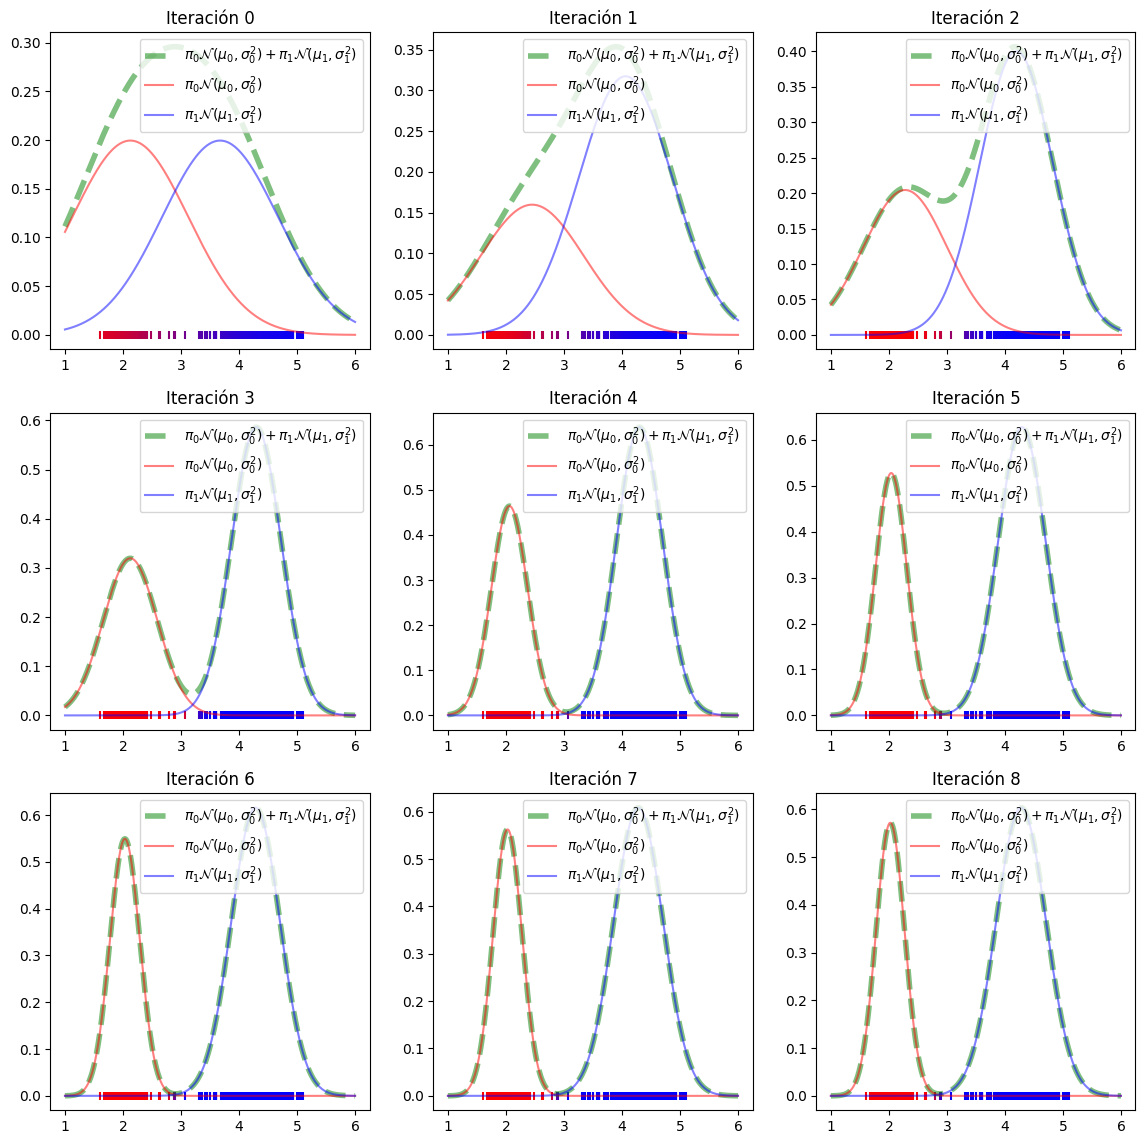

In [9]:
pi, mu, sigma, posteriori, vl = em(data['eruptions'], n_comp=2, n_iter=9)

Visualizamos la distribución final

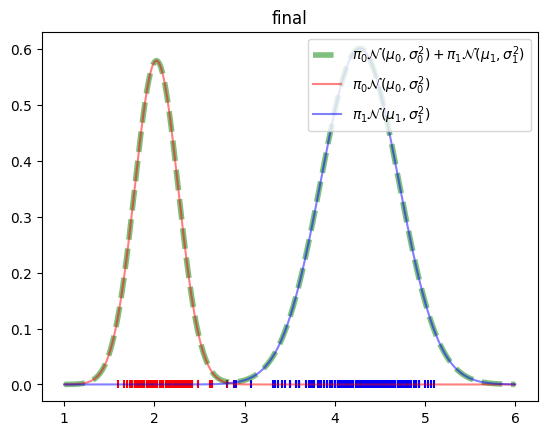

In [10]:
grafica_distribuciones(data['eruptions'], pi, mu, sigma, 2, posteriori, 'final')

Por último, graficamos la verosimilitud logarítmica en cada iteración


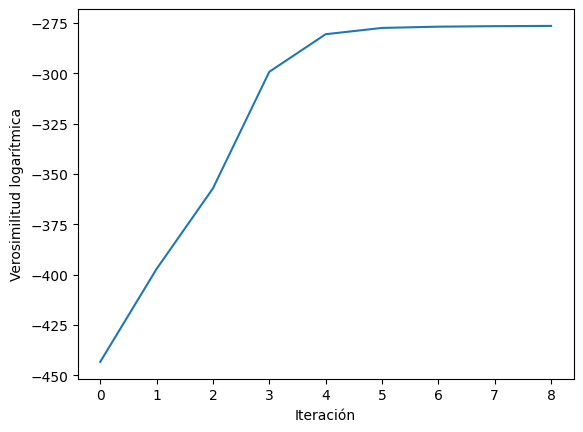

In [11]:
plt.plot(vl)
plt.xlabel('Iteración')
plt.ylabel('Verosimilitud logarítmica')
plt.show()